In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.model_selection import train_test_split

from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

pd.set_option('display.max_columns', None)

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
air = pd.read_csv('Train.csv')

In [3]:
air.head()

,Place_ID X Date,Date,Place_ID,target,target_min,target_max,target_variance,target_count,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,specific_humidity_2m_above_ground,temperature_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,L3_NO2_NO2_column_number_density,L3_NO2_NO2_slant_column_number_density,L3_NO2_absorbing_aerosol_index,L3_NO2_cloud_fraction,L3_NO2_sensor_altitude,L3_NO2_sensor_azimuth_angle,L3_NO2_sensor_zenith_angle,L3_NO2_solar_azimuth_angle,L3_NO2_solar_zenith_angle,L3_NO2_stratospheric_NO2_column_number_density,L3_NO2_tropopause_pressure,L3_NO2_tropospheric_NO2_column_number_density,L3_O3_O3_column_number_density,L3_O3_O3_effective_temperature,L3_O3_cloud_fraction,L3_O3_sensor_azimuth_angle,L3_O3_sensor_zenith_angle,L3_O3_solar_azimuth_angle,L3_O3_solar_zenith_angle,L3_CO_CO_column_number_density,L3_CO_H2O_column_number_density,L3_CO_cloud_height,L3_CO_sensor_altitude,L3_CO_sensor_azimuth_angle,L3_CO_sensor_zenith_angle,L3_CO_solar_azimuth_angle,L3_CO_solar_zenith_angle,L3_HCHO_HCHO_slant_column_number_density,L3_HCHO_cloud_fraction,L3_HCHO_sensor_azimuth_angle,L3_HCHO_sensor_zenith_angle,L3_HCHO_solar_azimuth_angle,L3_HCHO_solar_zenith_angle,L3_HCHO_tropospheric_HCHO_column_number_density,L3_HCHO_tropospheric_HCHO_column_number_density_amf,L3_CLOUD_cloud_base_height,L3_CLOUD_cloud_base_pressure,L3_CLOUD_cloud_fraction,L3_CLOUD_cloud_optical_depth,L3_CLOUD_cloud_top_height,L3_CLOUD_cloud_top_pressure,L3_CLOUD_sensor_azimuth_angle,L3_CLOUD_sensor_zenith_angle,L3_CLOUD_solar_azimuth_angle,L3_CLOUD_solar_zenith_angle,L3_CLOUD_surface_albedo,L3_AER_AI_absorbing_aerosol_index,L3_AER_AI_sensor_altitude,L3_AER_AI_sensor_azimuth_angle,L3_AER_AI_sensor_zenith_angle,L3_AER_AI_solar_azimuth_angle,L3_AER_AI_solar_zenith_angle,L3_SO2_SO2_column_number_density,L3_SO2_SO2_column_number_density_amf,L3_SO2_SO2_slant_column_number_density,L3_SO2_absorbing_aerosol_index,L3_SO2_cloud_fraction,L3_SO2_sensor_azimuth_angle,L3_SO2_sensor_zenith_angle,L3_SO2_solar_azimuth_angle,L3_SO2_solar_zenith_angle,L3_CH4_CH4_column_volume_mixing_ratio_dry_air,L3_CH4_aerosol_height,L3_CH4_aerosol_optical_depth,L3_CH4_sensor_azimuth_angle,L3_CH4_sensor_zenith_angle,L3_CH4_solar_azimuth_angle,L3_CH4_solar_zenith_angle
0,010Q650 X 2020-01-02,2020-01-02,010Q650,38.0,23.0,53.0,769.50,92,11.000000,60.200001,0.00804,18.516840,1.996377,-1.227395,0.000074,0.000156,-1.231330,0.006507,840209.874619,76.537512,38.634284,-61.736719,22.358167,0.000057,6156.074219,0.000017,0.119095,234.151102,0.000000,76.536426,38.593017,-61.752587,22.363665,0.021080,883.332451,267.017184,840138.461052,74.543393,38.622451,-61.789016,22.379054,-0.000010,0.000000,76.536426,38.593017,-61.752587,22.363665,0.000064,0.566828,NaN,NaN,0.000000,NaN,NaN,NaN,76.536426,38.593017,-61.752587,22.363665,NaN,-1.231330,840209.874619,76.537512,38.634284,-61.736719,22.358167,-0.000127,0.312521,-0.000040,-1.861476,0.000000,76.536426,38.593017,-61.752587,22.363665,1793.793579,3227.855469,0.010579,74.481049,37.501499,-62.142639,22.545118
1,010Q650 X 2020-01-03,2020-01-03,010Q650,39.0,25.0,63.0,1319.85,91,14.600000,48.799999,0.00839,22.546533,3.330430,-1.188108,0.000076,0.000197,-1.082553,0.018360,840772.941995,-14.708036,59.624912,-67.693509,28.614804,0.000055,6156.074219,0.000021,0.115179,233.313706,0.059433,-14.708036,59.624912,-67.693509,28.614804,0.022017,1148.985447,61.216687,841116.763051,-57.015200,61.402626,-74.457583,33.089495,0.000114,0.059433,-14.708036,59.624912,-67.693509,28.614804,0.000171,0.858446,175.019862,99354.162958,0.059358,5.958538,175.072145,99353.672374,-14.708036,59.624912,-67.693509,28.614804,0.315403,-1.082553,840772.941995,-14.708036,59.624912,-67.693509,28.614804,0.000150,0.433957,0.000050,-1.452612,0.059433,-14.708036,59.624912,-67.693509,28.614804,1789.960449,3384.226562,0.015104,75.630043,55.657486,-53.868134,19.293652
2,010Q650 X 2020-01-04,2020-01-04,010Q650,24.0,8.0,56.0,1181.96,96,16.400000,33.400002,0

In [4]:
air.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30557 entries, 0 to 30556
Data columns (total 82 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   Place_ID X Date                                      30557 non-null  object 
 1   Date                                                 30557 non-null  object 
 2   Place_ID                                             30557 non-null  object 
 3   target                                               30557 non-null  float64
 4   target_min                                           30557 non-null  float64
 5   target_max                                           30557 non-null  float64
 6   target_variance                                      30557 non-null  float64
 7   target_count                                         30557 non-null  int64  
 8   precipitable_water_entire_atmosphere                 30557 non-nul

In [5]:
air.isna().mean()

Place_ID X Date                 0.000000
Date                            0.000000
Place_ID                        0.000000
target                          0.000000
target_min                      0.000000
                                  ...   
L3_CH4_aerosol_optical_depth    0.810453
L3_CH4_sensor_azimuth_angle     0.810453
L3_CH4_sensor_zenith_angle      0.810453
L3_CH4_solar_azimuth_angle      0.810453
L3_CH4_solar_zenith_angle       0.810453
Length: 82, dtype: float64

In [6]:
def remove_missing(df):
    # drop columns with high missing values
    missing = df.isna().mean().sort_values(ascending=False)
    missing_over80 = missing[missing > 0.8]
    df = df.drop(columns=missing_over80.index)

    # drop rows with missing values
    df = df.dropna(axis='index')
    return df

In [7]:
non_empty_air = remove_missing(air)
non_empty_air.isna().sum().sum()

0

In [8]:
cols = ['target',
        'precipitable_water_entire_atmosphere',
        'relative_humidity_2m_above_ground',
        'specific_humidity_2m_above_ground',
        'temperature_2m_above_ground',
        'u_component_of_wind_10m_above_ground',
        'v_component_of_wind_10m_above_ground',
        'L3_NO2_NO2_column_number_density',
        'L3_NO2_NO2_slant_column_number_density',
        'L3_NO2_tropospheric_NO2_column_number_density',
        'L3_NO2_solar_azimuth_angle',
        'L3_O3_solar_azimuth_angle',
        'L3_CO_CO_column_number_density',
        'L3_CO_solar_azimuth_angle',
        'L3_HCHO_HCHO_slant_column_number_density',
        'L3_HCHO_solar_azimuth_angle',
        'L3_HCHO_tropospheric_HCHO_column_number_density',
        'L3_CLOUD_solar_azimuth_angle',
        'L3_AER_AI_sensor_altitude',
        'L3_AER_AI_solar_azimuth_angle',
        'L3_SO2_solar_azimuth_angle']


In [9]:
data = non_empty_air[cols]

**Remove Outliers**

In [10]:
i = non_empty_air[non_empty_air['target'] > 200].index
dwo = non_empty_air.drop(i,axis='index')
final_dwo = dwo[cols]

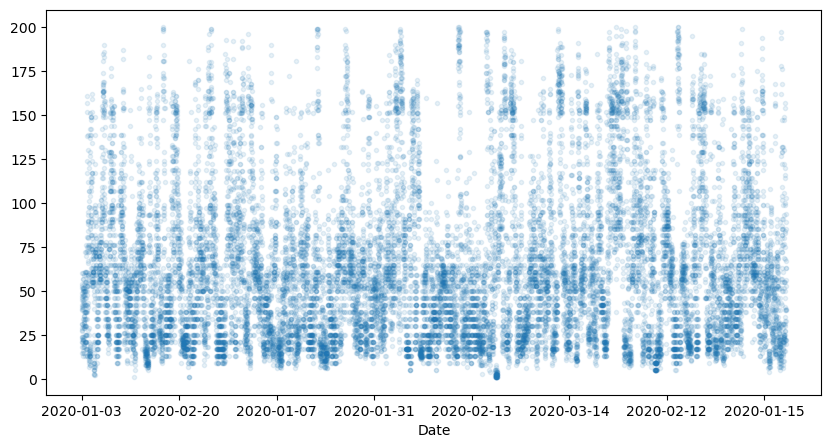

In [11]:
dwo.set_index('Date')['target'].plot(style='.',alpha=0.1, figsize=[10,5]);

**Split**

In [12]:
x_dwo = final_dwo.drop(columns='target')
y_dwo = final_dwo['target']

In [13]:
xwo_train, xwo_test, ywo_train, ywo_test = train_test_split(x_dwo,y_dwo,test_size=0.2,random_state=42)

In [14]:
from sklearn.model_selection import cross_val_score

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

scaler = StandardScaler()

pipe = Pipeline([('std_scaler', scaler)])

xwo_prepared = pipe.fit_transform(xwo_train)

**XGBoost**

In [16]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor()

xgb_model.fit(xwo_prepared,ywo_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [17]:
x_test_prepared = pipe.fit_transform(xwo_test)
xgb_preds = xgb_model.predict(x_test_prepared)
xgb_rmse_score = mean_squared_error(ywo_test,xgb_preds,squared=False)
print('xgb_score:',xgb_rmse_score)

xgb_score: 28.89197076074514


In [116]:
from sklearn.model_selection import GridSearchCV

parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'n_estimators': [500],"learning_rate": [0.05, 0.10, 0.15],
              "max_depth": [ 3, 4, 5, 6, 7, 8,9,10],
                "min_child_weight": [ 1, 3, 5, 7],"gamma":[ 0.0, 0.1, 0.2],
                "colsample_bytree":[ 0.3, 0.4]}

In [120]:
xgb_grid = GridSearchCV(xgb_model, parameters, cv=3, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)

In [ ]:
%%time
xgb_grid.fit(xwo_prepared,ywo_train)